<a href="https://colab.research.google.com/github/Richish/spark_on_gpus/blob/main/02_spark_sql_and_dataframe_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install pyspark
!pip install ipython-autotime
%load_ext autotime
import pyspark

     |████████████████████████████████| 212.3MB 66kB/s 
     |████████████████████████████████| 204kB 36.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=3272d0b68a9a349b59c1ac4c7dc244079b8c074fdb7927bfba3e69d8869fbc3e
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
time: 83.8 ms (started: 2021-04-17 15:06:55 +00:00)


In [8]:

from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/
ls: cannot access 'MyDrive/colab_notebooks/datasets/taxi-small/': No such file or directory
time: 24.3 s (started: 2021-04-17 15:09:29 +00:00)


In [12]:
!ls /content/drive/MyDrive/colab_notebooks/datasets/taxi-small/
train_file = "/content/drive/MyDrive/colab_notebooks/datasets/taxi-small/train/taxi-small.csv"
eval_file = "/content/drive/MyDrive/colab_notebooks/datasets/taxi-small/eval/taxi-small.csv"
test_file = "/content/drive/MyDrive/colab_notebooks/datasets/taxi-small/trainWithEval/test.csv"

eval  train  trainWithEval
time: 116 ms (started: 2021-04-17 15:11:05 +00:00)


In [13]:
# defining scema
from pyspark.sql.types import StructType, StructField, StructField, DoubleType, IntegerType
schema = StructType([
StructField("vendor_id", DoubleType()),
StructField("passenger_count", DoubleType()),
StructField("trip_distance", DoubleType()),
StructField("pickup_longitude", DoubleType()),
StructField("pickup_latitude", DoubleType()),
StructField("rate_code", DoubleType()),
StructField("store_and_fwd", DoubleType()),
StructField("dropoff_longitude", DoubleType()),
StructField("dropoff_latitude", DoubleType()),
StructField("fare_amount", DoubleType()),
StructField("hour", DoubleType()),
StructField("year", IntegerType()),
StructField("month", IntegerType()),
StructField("day", DoubleType()),
StructField("day_of_week", DoubleType()),
StructField("is_weekend", DoubleType()) ])

time: 16.4 ms (started: 2021-04-17 15:11:51 +00:00)


In [16]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Taxi").getOrCreate()

time: 7.88 s (started: 2021-04-17 15:15:36 +00:00)


In [20]:
# load data into dataframe and cache
train_df = spark.read.option("inferSchema", False).schema(schema).option("header", True).csv(train_file)

time: 113 ms (started: 2021-04-17 15:22:08 +00:00)


In [21]:
# cache data in coulmnar format in memory
train_df.cache

<bound method DataFrame.cache of DataFrame[vendor_id: double, passenger_count: double, trip_distance: double, pickup_longitude: double, pickup_latitude: double, rate_code: double, store_and_fwd: double, dropoff_longitude: double, dropoff_latitude: double, fare_amount: double, hour: double, year: int, month: int, day: double, day_of_week: double, is_weekend: double]>

time: 7.91 ms (started: 2021-04-17 15:22:10 +00:00)


In [22]:
# create table view of dataframe for sparksql
train_df.createOrReplaceTempView("train_taxi")

time: 792 ms (started: 2021-04-17 15:22:28 +00:00)


In [23]:
# cache table in columnar format in memory
spark.catalog.cacheTable("train_taxi")

time: 203 ms (started: 2021-04-17 15:23:52 +00:00)


In [30]:
# after df is registered as a table view in memory we directly use spark sql
!%sql
select hour, avg(fair_amount) from train_taxi group by hour order by hour # doesn't work in colab

SyntaxError: ignored

In [40]:
# same thing on dataframe
train_df.select("hour","fare_amount").groupBy("hour").avg("fare_amount").orderBy("hour").show(5)

+----+------------------+
|hour|  avg(fare_amount)|
+----+------------------+
| 0.0|11.083333333333334|
| 1.0|22.581632653061224|
| 2.0|11.370820668693009|
| 3.0|13.873989218328841|
| 4.0| 14.57204433497537|
+----+------------------+
only showing top 5 rows

time: 2.36 s (started: 2021-04-17 15:38:01 +00:00)


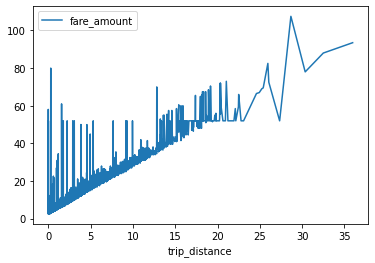

time: 2.2 s (started: 2021-04-17 15:49:51 +00:00)


In [50]:
# what is avg fare amount compared to avg trip distance
train_df.columns
dist_vs_fare = train_df.select("trip_distance", "fare_amount").orderBy("trip_distance")
pd_dist_vs_fare = dist_vs_fare.toPandas()
pd_dist_vs_fare.plot(x="trip_distance", y="fare_amount", kind="line", logy=False)

In [56]:
# what is avg fare amt and avg trip distance by hour of day
avgs = train_df.select("hour", "trip_distance", "fare_amount").groupBy("hour").avg("trip_distance", "fare_amount").orderBy("hour")#.show()


time: 73.9 ms (started: 2021-04-17 15:55:27 +00:00)


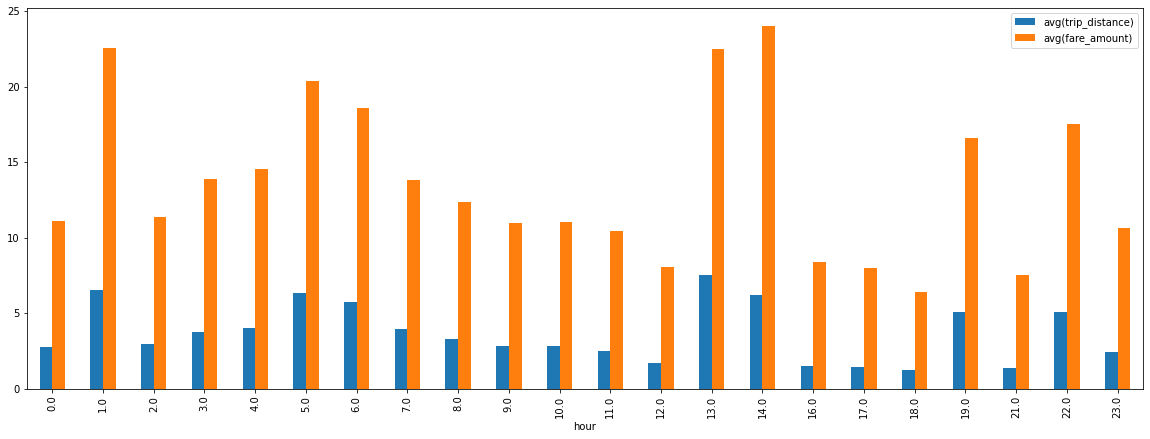

time: 860 ms (started: 2021-04-17 15:59:35 +00:00)


In [63]:
pd_avgs = avgs.toPandas()
pd_avgs.plot(kind="bar", x="hour", figsize=(20,7))

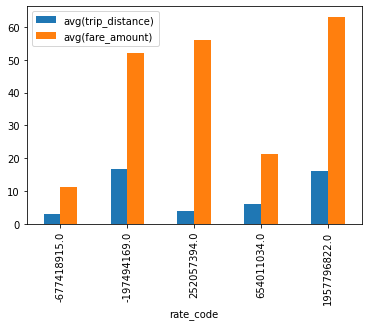

time: 3.25 s (started: 2021-04-17 16:07:05 +00:00)


In [71]:
# average trip distance and avg fare amout by rate_code
avgs_by_rate_code = train_df.select("rate_code", "trip_distance", "fare_amount").groupBy("rate_code").avg("trip_distance", "fare_amount").orderBy("rate_code")
avgs_by_rate_code.toPandas().plot(kind="bar", x="rate_code")

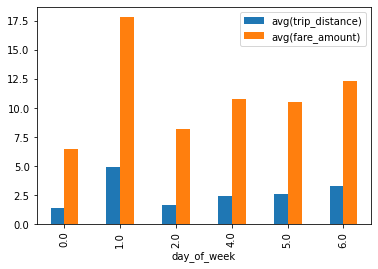

time: 2.91 s (started: 2021-04-17 16:09:39 +00:00)


In [75]:
# avg fare amount and avg distance by day of week
avgs_by_weekday = train_df.select("day_of_week", "trip_distance", "fare_amount").groupBy("day_of_week").avg("trip_distance", "fare_amount").orderBy("day_of_week")
avgs_by_weekday.toPandas().plot(kind="bar", x="day_of_week")